# Compare the LSST magnitudes I calculate to those from TRILEGAL

Should I use Kurucz atmospheres?

https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/resBasedDoc/kuruczModels.html

https://pysynphot.readthedocs.io/en/latest/spectrum.html

In [1]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/vespa_update')
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from newLSSTEBWorker import LSSTEBWorker
from SED import SED
import pandas as pd
import numpy as np
from astropy import units, constants 
from matplotlib import pyplot as plt
%matplotlib inline

#%load_ext autoreload
#%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
def getRad(logg, m):
    #g = GM/r**2
    g = 10.**logg * units.cm/units.s**2.
    r = ((constants.G*m*units.Msun/g)**0.5).decompose().to(units.Rsun).value
    return r

*Read in a TRILEGAL field*

In [4]:
filename = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/testing/TRILEGAL/grid/TRILEGAL_model_fID390.h5'
df = pd.read_hdf(filename)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec

dist = 10.**( (df['m-M0'].values + 5)/5.) #pc
logDist = np.log10(dist/1000.) #log(d [kpc])
logR = np.log10(getRad(df['logg'].values, df['Mact'].values))

df['logR'] = logR
df['logDist'] = logDist

print(df)

        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    6.65  -0.35  1.75924  1.098  3.967  4.398  13.9  5.662    0.0   
1        1    6.65  -0.33  9.22456  3.651  4.390  4.258  13.9  5.905    0.0   
2        1    6.65  -0.31  3.03816  1.989  4.129  4.395  13.3  4.950    0.0   
3        1    6.65  -0.29  1.16075  0.226  3.811  4.466  12.6  4.327    0.0   
4        1    6.65  -0.27  2.24251  1.489  4.036  4.391  13.4  4.464    0.0   
5        1    6.65  -0.23  1.52547  0.801  3.895  4.348  11.7  3.481    0.0   
6        1    6.65  -0.21  1.53534  0.807  3.895  4.344  11.3  2.763    0.0   
7        1    6.65  -0.19  0.70111 -0.818  3.662  4.695  11.4  2.864    0.0   
8        1    6.65  -0.19  1.59277  0.873  3.907  4.340  13.5  4.244    0.0   
9        1    6.65  -0.19  2.36859  1.558  4.042  4.369  14.6  5.942    0.0   
10       1    6.65  -0.17  0.99625 -0.120  3.757  4.532   9.0  1.113    0.0   
11       1    6.65  -0.17  0.67534 -0.893  3.653  4.

*Create an EB in my code*

In [5]:
worker = LSSTEBWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.useOpSimDates = False
np.random.seed()

In [6]:
#dummy class so that I can use my EclipsingBinary code
class OpSim(object):
    def __init__(self, N):
        self.RA = np.zeros(N)
        self.Dec = np.zeros(N)

In [7]:
diff = {}
diff['mbol'] = []
diff['Teff'] = []
diff['MH'] = []
diff['Av'] = []
diff['Ldiff'] = []
diff['u'] = []
diff['g'] = []
diff['r'] = []
diff['i'] = []
diff['z'] = []
diff['y'] = []

N = 100
worker.OpSim = OpSim(N)

for i in range(N):
    print(i)
    if (df['logg'][i] > 3):
        L1 = 10.**df['logL'][i]
        L2 = 1e-20
        r1 = 10.**df['logR'][i]
        r2 = 1e-20
        T1 = 10.**df['logTe'][i]
        T2 = 5000.
        g1 = df['logg'][i]
        g2 = 4.
        dist = 10.**df['logDist'][i]
        Av = df['Av'][i]
        M_H = df['[M/H]'][i]

        line = [1., 1., 1., 0., r1, r2, L1, L2, 1., 1., 1., dist, 0., 0., 0., Av, M_H, T1, T2, g1, g2]
        print(line)
        try:
            EB = worker.getEB(line, i)

        #     print(EB.T1, 10.**df['logTe'][i])
        #     print(EB.Mbol, df['mbol'][i] - df['m-M0'][i])

        #     print(EB.appMagMean)
        #     print(dfmags.iloc[i])

            diff['mbol'].append(df['mbol'][i])
            diff['Teff'].append(EB.T1)
            diff['Av'].append(Av)
            diff['MH'].append(M_H)
        #     diff['Ldiff'].append(L1 - EB.Ltest)
            diff['u'].append(df['u_mag'][i] - EB.appMagMean['u_'])
            diff['g'].append(df['g_mag'][i] - EB.appMagMean['g_'])
            diff['r'].append(df['r_mag'][i] - EB.appMagMean['r_'])
            diff['i'].append(df['i_mag'][i] - EB.appMagMean['i_'])
            diff['z'].append(df['z_mag'][i] - EB.appMagMean['z_'])
            diff['y'].append(df['Y_mag'][i] - EB.appMagMean['y_'])
            #print(10.**df.iloc[i]['logTe'])
            print(10.**df['logTe'][i],\
                  df['u_mag'][i] - EB.appMagMean['u_'],\
                  df['g_mag'][i] - EB.appMagMean['g_'],\
                  df['r_mag'][i] - EB.appMagMean['r_'],\
                  df['i_mag'][i] - EB.appMagMean['i_'],\
                  df['z_mag'][i] - EB.appMagMean['z_'],\
                  df['Y_mag'][i] - EB.appMagMean['y_'])
        #           L1 - EB.Ltest)
        #     print(diff)
        #     if (i>2):
        #         raise
        except:
            print("WARNING: bad input values")

0
[1.0, 1.0, 1.0, 0.0, 1.3888864258016187, 1e-20, 12.531411749414156, 1e-20, 1.0, 1.0, 1.0, 6.025595860743575, 0.0, 0.0, 0.0, 5.662000000000001, -0.35, 9268.298233793494, 5000.0, 4.398, 4.0]
9268.298233793494 -0.06257025400778105 -0.03199709827445929 0.2699924356175245 0.44275067226785936 0.29065241602933867 0.1964952421001307
1
[1.0, 1.0, 1.0, 0.0, 3.736542427892304, 1e-20, 4477.133041763628, 1e-20, 1.0, 1.0, 1.0, 6.025595860743575, 0.0, 0.0, 0.0, 5.905, -0.33, 24547.089156850285, 5000.0, 4.258, 4.0]
24547.089156850285 -0.021077115550159675 -0.02238016284820432 0.278551956240495 0.45894692400788273 0.2993770630103274 0.17789930356926753
2
[1.0, 1.0, 1.0, 0.0, 1.831587615853196, 1e-20, 97.49896377173872, 1e-20, 1.0, 1.0, 1.0, 4.570881896148752, 0.0, 0.0, 0.0, 4.95, -0.31, 13458.60354055947, 5000.0, 4.395, 4.0]
13458.60354055947 -0.04453037303682805 -0.026698975334415564 0.2297377895315975 0.3804131165075617 0.24779808455196317 0.14686972405967325
3
[1.0, 1.0, 1.0, 0.0, 1.04339781643720

5321.082592667947 -0.026648278278916138 -0.06872726731508294 0.16229718595116438 0.2703501988484014 0.1758404991649236 0.14491199154804235
26
[1.0, 1.0, 1.0, 0.0, 2.240728799982965, 1e-20, 213.30449131465772, 1e-20, 1.0, 1.0, 1.0, 5.248074602497728, 0.0, 0.0, 0.0, 4.1, -0.11, 14825.180851459545, 5000.0, 4.325, 4.0]
14825.180851459545 -0.032176968555162944 -0.017771216376424093 0.19142028244454679 0.31614329096931826 0.20472212375032584 0.11113063638527265
27
[1.0, 1.0, 1.0, 0.0, 1.6130057051845028, 1e-20, 19.906733389871874, 1e-20, 1.0, 1.0, 1.0, 7.585775750291836, 0.0, 0.0, 0.0, 5.609, -0.11, 9638.290236239705, 5000.0, 4.332, 4.0]
9638.290236239705 -0.06243643414720523 -0.029403397210774784 0.2694736736278216 0.4408597883198162 0.2908553188788723 0.1937147887303574
28
[1.0, 1.0, 1.0, 0.0, 2.548895017087493, 1e-20, 477.5292736576907, 1e-20, 1.0, 1.0, 1.0, 12.02264434617413, 0.0, 0.0, 0.0, 6.361000000000001, -0.11, 16982.43652461746, 5000.0, 4.312, 4.0]
16982.43652461746 -0.031863119083

14554.59080581967 -0.04305173255800554 -0.030626297658621127 0.2784386144079285 0.461032061567483 0.30089280176707334 0.187220826066131
52
[1.0, 1.0, 1.0, 0.0, 1.6747720372226087, 1e-20, 18.323144223712113, 1e-20, 1.0, 1.0, 1.0, 2.884031503126606, 0.0, 0.0, 0.0, 4.0969999999999995, -0.01, 9268.298233793494, 5000.0, 4.294, 4.0]
9268.298233793494 -0.05501286326851229 -0.01910413609758521 0.19983886589443145 0.3229582477905808 0.21334292992684922 0.1353501211519692
53
[1.0, 1.0, 1.0, 0.0, 1.0221587492046604, 1e-20, 1.1220184543019633, 1e-20, 1.0, 1.0, 1.0, 3.3113112148259143, 0.0, 0.0, 0.0, 3.447, -0.01, 5902.0108017184475, 5000.0, 4.462, 4.0]
5902.0108017184475 -0.04508628059819131 -0.05948936094949886 0.16057219863508365 0.268659401394018 0.17535613953524276 0.1341046598388118
54
[1.0, 1.0, 1.0, 0.0, 1.9753809495570076, 1e-20, 72.61059574351547, 1e-20, 1.0, 1.0, 1.0, 4.365158322401657, 0.0, 0.0, 0.0, 5.127000000000001, -0.01, 12050.359403717986, 5000.0, 4.312, 4.0]
12050.359403717986 -0

6039.4862937638 -0.04739087280466592 -0.06366248323275059 0.21782714232438138 0.36321302318686577 0.2378499333396782 0.1813545388637685
78
[1.0, 1.0, 1.0, 0.0, 3.2410790097180464, 1e-20, 1318.2567385564075, 1e-20, 1.0, 1.0, 1.0, 10.0, 0.0, 0.0, 0.0, 7.145, 0.07, 19408.858775927794, 5000.0, 4.229, 4.0]
19408.858775927794 -0.04033942064976159 -0.039305740298051006 0.3297967146915397 0.5488670574903907 0.35628849890382597 0.2252441860475578
79
[1.0, 1.0, 1.0, 0.0, 0.6055408199925578, 1e-20, 0.11939881044642733, 1e-20, 1.0, 1.0, 1.0, 1.6595869074375613, 0.0, 0.0, 0.0, 2.73, 0.09, 4385.306977749856, 5000.0, 4.712, 4.0]
4385.306977749856 -0.0421587727758741 -0.05933014931276048 0.13964902319753492 0.2152253015605794 0.13721546715213506 0.13401984833203784
80
[1.0, 1.0, 1.0, 0.0, 1.5608191877531654, 1e-20, 7.194489780036995, 1e-20, 1.0, 1.0, 1.0, 3.1622776601683795, 0.0, 0.0, 0.0, 4.905, 0.09, 7603.262769401822, 5000.0, 4.2669999999999995, 4.0]
7603.262769401822 -0.060153979089200504 -0.04070

In [6]:
# check the data file where there is a WARNING (it indeed is missing the data for that combination -- all zeros)
# from astropy.io import fits  
# fname='/Users/ageller/python_scripts/PySynphotData/grid/ck04models/ckp00/ckp00_34000.fits'
# with fits.open(fname) as hdul:
#     hdul.info()
#     print(hdul[0].header)
# data = fits.getdata(fname, 0)
# print(data[0])
# print(data.shape)

# some plots.

It looks like the difference is due to the extinction law, but I think/hope this is OK as is.  

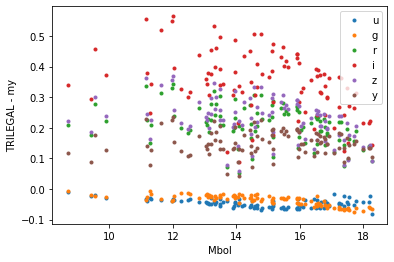

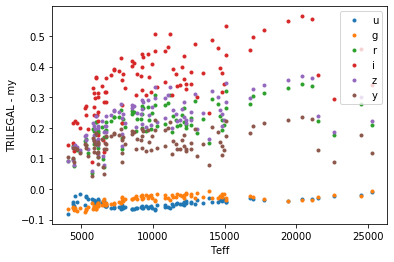

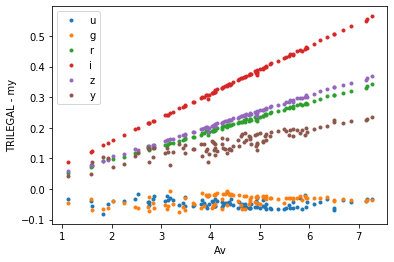

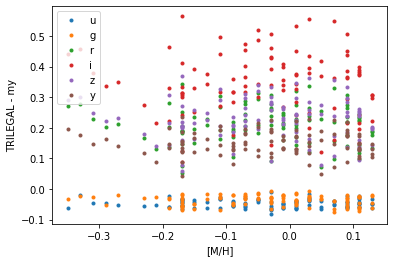

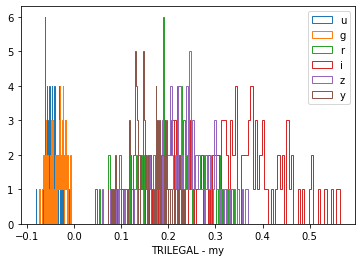

In [8]:
f, ax = plt.subplots()
ax.plot(diff['mbol'], diff['u'],'.', label='u')
ax.plot(diff['mbol'], diff['g'],'.', label='g')
ax.plot(diff['mbol'], diff['r'],'.', label='r')
ax.plot(diff['mbol'], diff['i'],'.', label='i')
ax.plot(diff['mbol'], diff['z'],'.', label='z')
ax.plot(diff['mbol'], diff['y'],'.', label='y')
ax.set_xlabel('Mbol')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.plot(diff['Teff'], diff['u'],'.', label='u')
ax.plot(diff['Teff'], diff['g'],'.', label='g')
ax.plot(diff['Teff'], diff['r'],'.', label='r')
ax.plot(diff['Teff'], diff['i'],'.', label='i')
ax.plot(diff['Teff'], diff['z'],'.', label='z')
ax.plot(diff['Teff'], diff['y'],'.', label='y')
ax.set_xlabel('Teff')
ax.set_ylabel('TRILEGAL - my')
ax.legend()


f, ax = plt.subplots()
ax.plot(diff['Av'], diff['u'],'.', label='u')
ax.plot(diff['Av'], diff['g'],'.', label='g')
ax.plot(diff['Av'], diff['r'],'.', label='r')
ax.plot(diff['Av'], diff['i'],'.', label='i')
ax.plot(diff['Av'], diff['z'],'.', label='z')
ax.plot(diff['Av'], diff['y'],'.', label='y')
ax.set_xlabel('Av')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.plot(diff['MH'], diff['u'],'.', label='u')
ax.plot(diff['MH'], diff['g'],'.', label='g')
ax.plot(diff['MH'], diff['r'],'.', label='r')
ax.plot(diff['MH'], diff['i'],'.', label='i')
ax.plot(diff['MH'], diff['z'],'.', label='z')
ax.plot(diff['MH'], diff['y'],'.', label='y')
ax.set_xlabel('[M/H]')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.hist(diff['u'],histtype='step', label='u', bins=100)
ax.hist(diff['g'],histtype='step', label='g', bins=100)
ax.hist(diff['r'],histtype='step', label='r', bins=100)
ax.hist(diff['i'],histtype='step', label='i', bins=100)
ax.hist(diff['z'],histtype='step', label='z', bins=100)
ax.hist( diff['y'],histtype='step', label='y', bins=100)
ax.set_xlabel('TRILEGAL - my')
ax.legend()

# f, ax = plt.subplots()
# ax.plot(diff['Teff'], diff['Ldiff'],'.', label='u')
# ax.set_xlabel('Teff')
# ax.set_ylabel('L TRILEGAL - my')
# ax.set_ylim(-2,1)
# ax.legend()

False
0
3.123 90.0 0.05643548704757422 0.05643548704757422 1.0 1.0


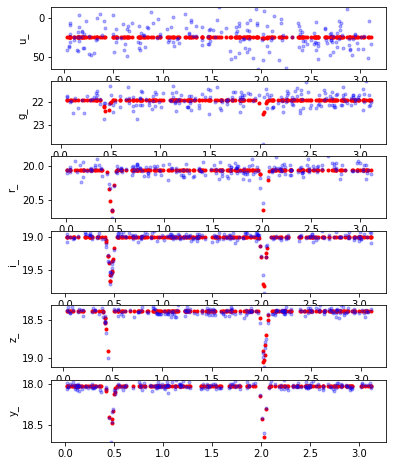

In [26]:
i=0
print(worker.useOpSimDates)
print(i)
L1 = 10.**df['logL'][i]
L2 = 10.**df['logL'][i]
r1 = 10.**df['logR'][i]
r2 = 10.**df['logR'][i]
T1 = 10.**df['logTe'][i]
T2 = 10.**df['logTe'][i]
g1 = df['logg'][i]
g2 = df['logg'][i]
dist = 10.**df['logDist'][i]
Av = df['Av'][i]
M_H = df['[M/H]'][i]

line = [1., 1., 1., 0., r1, r2, L1, L2, 1., 1., 1., dist, 0., 0., 0., Av, M_H, T1, T2, g1, g2]
EB = worker.getEB(line, i)
EB.inclination = 90.
EB.period = 3.123

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

fig,ax = plt.subplots(6,1, figsize=(6,8))
for i,f in enumerate(worker.filters):
    EB.observe(f)

    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMag[f],'.', color='red')
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMagObs[f],'.', alpha=0.3, color='blue')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)


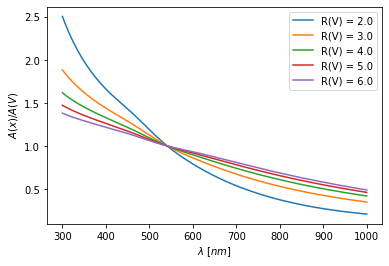

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from dust_extinction.parameter_averages import F04

fig, ax = plt.subplots()

# temp model to get the correct x range
text_model = F04()

# generate the curves and plot them
# x = np.arange(text_model.x_range[0],
#               text_model.x_range[1],0.1)/u.micron

x = np.arange(300,1000, 0.1 )*u.nm

Rvs = ['2.0','3.0','4.0','5.0','6.0']
for cur_Rv in Rvs:
    ext_model = F04(Rv=cur_Rv)
    ax.plot(x,ext_model(x),label='R(V) = ' + str(cur_Rv))

ax.set_xlabel('$\lambda$ [$nm$]')
ax.set_ylabel('$A(x)/A(V)$')

ax.legend(loc='best')
plt.show()

In [7]:
#https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/resBasedDoc/kuruczModels.html
#from PyAstronomy import pyasl
#running the command in the next cell for the first time, will download data
# The input is: Teff, logg, and log10(metallicity), but ... this doesn't give fluxes??
# model = pyasl.getKuruczModel(4250, 4.5, 0.0)
# print(model)
#f,ax = plt.subplot()

/Users/ageller/python_scripts/PySynphotData/
angstrom
flam


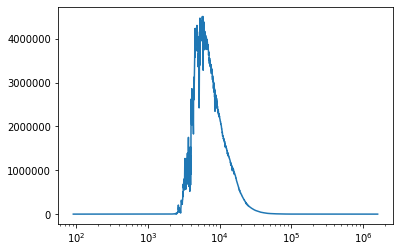

In [28]:
#https://pysynphot.readthedocs.io/en/latest/index.html#pysynphot-installation-setup
#need to download grid of models manually, and set path accordingly
from astropy.io import fits
import pysynphot as pyS

import os
#export PYSYN_CDBS=/my/local/dir/cdbs/
print(os.environ['PYSYN_CDBS'])

#Teff, M/H, logg
sp = pyS.Icat('ck04models', 5000, 0.12, 5.0)
print(sp.waveunits)
print(sp.fluxunits)
f,ax = plt.subplots()
ax.semilogx(sp.wave, sp.flux)#,'.')
#ax.set_xlim(3000, 4000)



In [9]:
print((constants.h * 1*units.Hz).cgs)

6.62607004e-27 erg


In [10]:
#pyS.reddening.print_red_laws()
pyS.Extinction(0.1, 'gal3')(10000)

0.890721221431598